## 머신러닝 - 회귀분석

### 회귀 분석과 오차의 성질 1

In [6]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import random
import tensorflow
import tensorflow as tf

import pandas as pd # 판다스와 넘파이 데이터 구조를 관리한다. 전처리와 출력에 주로 사용.
import seaborn as sb

import numpy as np

import matplotlib # 메틀랩 회사에서 만든건데 화면에 그래프 그려줌
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.callbacks import EarlyStopping # 학습 자동 중지
from tensorflow.keras import regularizers   # L1, L2 규제 적용
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
 
from sklearn.preprocessing import LabelEncoder  # class가 문자열인경우 변환
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋을 나눔
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import platform 

if (platform.system() == 'Windows'):  # Windows
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    plt.rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd/rnn/naver_movie' # Colab

plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

# Jupyter에게 matplotlib 그래프를 출력 영역에 표시할 것을 지시하는 명령
%matplotlib inline  

In [7]:
X = [i for i in range(6)]  # 0 ~ 5: 공부시간
print(X)

[0, 1, 2, 3, 4, 5]


In [8]:
# y = ax + b, y = 2x + 20, 기울기와 y 절편이 결정된 경우
a = 2  # 임의로 지정
b = 20 # 임의로 지정
Y = [(a * x) + b for x in X]
print(Y) # 공부를 전혀 안해도 20점, 5시간을 공부하면 30점 취득 예상 

[20, 22, 24, 26, 28, 30]


In [9]:
# a(기울기, y의 변화량/x의 변화량)의 특징 분석
# y = ax + b
Y1 = [(5 * x) + 20 for x in X]  # f(x) = 5x + 20
Y2 = [(10 * x) + 20 for x in X] # f(x) = 10x + 20
Y3 = [(20 * x) + 20 for x in X] # f(x) = 20x + 20
print('Y1:', Y1) # 0 *  5 + 20 = 20, 1 * 5 + 20 = 25
print('Y2:', Y2) # 0 * 10 + 20 = 20, 1 * 10 + 20 = 30
print('Y3:', Y3) # 0 * 20 + 20 = 20, 1 * 20 + 20 = 40

Y1: [20, 25, 30, 35, 40, 45]
Y2: [20, 30, 40, 50, 60, 70]
Y3: [20, 40, 60, 80, 100, 120]


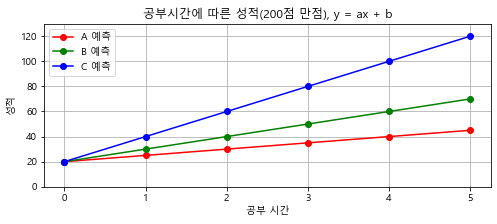

In [17]:
plt.figure(figsize=(8, 3)) # 단위: 인치
# X 공부 시간, Y: 실제 취득 성적
plt.plot(X, Y1, color='red', linestyle='solid', marker='o', label='A 예측')
plt.plot(X, Y2, color='green', linestyle='solid', marker='o', label='B 예측')
plt.plot(X, Y3, color='blue', linestyle='solid', marker='o', label='C 예측')
plt.ylim(0, 130) # y limit: 범위
plt.grid(True) # 격자 출력
plt.title('공부시간에 따른 성적(200점 만점), y = ax + b')
plt.xlabel('공부 시간')
plt.ylabel('성적')
plt.legend()
plt.show()
# a에 어떤수를 지정하는가에 따라 공부시간당 성적이 변경됨.
# b: y 절편, 편향, Bias, 곱하기의 성질상 x가 0이면 무조건 0이되는 문제 해결

In [6]:
# f(x) = ax + b: x -> f(x): 결과, 원인과 결과, 단순 선형회귀, 1차 함수 그래프
y = 2 * 6 + 20
print('6시간 공부한 경우의 예측: ', y, '점')
# 기울기 a와, y 절편 b에 따라 점수 예측 정확도 결정됨.

6시간 공부한 경우의 예측:  32 점


In [7]:
# f(x) = ax + b에서 추론 통계를 이용하여 a, b 산출 가능
# 데이터가 많아지면 a₁, a₂, a₃....복잡해서 산출이 매우 어려움.
# 매출액 = [x₁: 광고 횟수, x₂: 광고 비용, x₃: 방송사]
# 성적 = [x₁: 자율학습 시간, x₂: 보충 수업, x₃: 시험 응시 횟수]
# f(x) = a₁x₁ + a₂x₂+ a₃x₃+ b : 변수마다 기울기 존재, bias는 1개만 존재

# 머신러닝(인공지능)이 하는 역할은
# 최소 오차를 발생시키는 기울기 a와, y 절편 b를 찾는 역활을 함.
# 현실데이터의 특성상 오차는 존재 할 수 밖에 없음.

### 단순선형회귀 실습
- Y = aX+b
- a= (∑XY - nXbarYbar) / (∑X²-nXbar²)
- b = Ybar - aXbar

In [18]:
X = [v for v in range(0, 10)] # 독립 변수
print(X)
Y = [(x * 2) for x in X]
# Y = [(x * 3) for x in X]
# Y = [(x * 3)+5 for x in X]
# Y = [(((x * 3)+5 / 2.5) * 1.75) for x in X] # 종속 변수
print(Y)
# 10이 등장하는 경우 어떤 수가 와야하는지 예측하는 모델 제작, 답은 20이 와야함. 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [10]:
X = np.array(X)
Y = np.array(Y)

Ybar = Y.mean() # Ybar, Y 평균
print('Ybar:', Ybar)

Xbar = X.mean()  # Xbar, X 평균
print('Xbar:', Xbar)

Ybar: 9.0
Xbar: 4.5


In [11]:
# ∑XY
tot = 0
for i in range(0, len(X)):
    # print(i)
    tot = tot + (X[i] * Y[i])
    
print('tot:', tot)

# nXbarYbar
nXbarYbar = len(X) * Xbar * Ybar
print('nXbarYbar:', nXbarYbar)

# ∑X²
X_square = [v ** 2 for v in X]
print('Xsquare:', X_square)
print('Xsquare:', sum(X_square))

# nXbar²
nXbar_square = len(X) * (Xbar ** 2)
print('nXbar_square:', nXbar_square)

tot: 570
nXbarYbar: 405.0
Xsquare: [0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
Xsquare: 285
nXbar_square: 202.5


In [12]:
# Y = aX+b
a= (tot - nXbarYbar) / (sum(X_square) - nXbar_square) # 기울기
b = Ybar - a * Xbar # 편향
print('완성된 모델: Y = {0} x X + {1}'.format(a, b))

완성된 모델: Y = 2.0 x X + 0.0


In [22]:
Y = (a * 10 + b)
print('x: 10 -> y: {0}'.format(Y))

x: 10 -> y: 40


In [16]:
(10 * 2) # 검증
# (((10 * 3)+5 / 2.5) * 1.75) # 검증

20

데이터: [0, 1, 2, 3, 4, 5]
모델에 의한 예측: [50, 52, 54, 56, 58, 60]


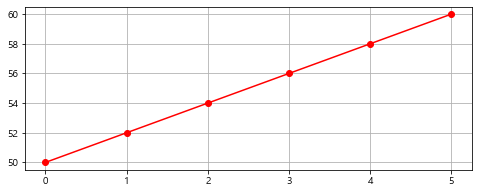

In [17]:
# y = ax + b, y = 2x + 50, 기울기와 y 절편이 결정된 경우
X = [i for i in range(6)]  # 0 ~ 5: 공부 시간
print('데이터:', X)
a = 2   # 기울기
b = 50  # 편향
p = [(a * x) + b for x in X] # 공식에의한 값 예측, p: Predict
print('모델에 의한 예측:', p)

plt.figure(figsize=(8, 3)) # 단위: 인치
plt.plot(X, p, color='red', linestyle='solid', marker='o')  # 예측 성적
plt.grid(True)
plt.show()

In [18]:
test = p.copy()
test[0] = 100
print(test)
print(p)

[100, 52, 54, 56, 58, 60]
[50, 52, 54, 56, 58, 60]


In [19]:
r = p.copy() # deep copy

# 3시간 공부한 경우의 학생은 집중력이 높아 6점이 더 향상됨. 
r[3] = r[3] + 6       
print('실제 취득 성적:', r)

실제 취득 성적: [50, 52, 54, 62, 58, 60]


In [20]:
# 공부시간 대비 일정하게 성적이 증가한다는 규칙이 깨짐.
# 이런 데이터의 발생은 평범한 일반적인 현상임.
err = 0  # 오차
for i in range(6):  # 0 ~ 5 
    fmt = '공부한 시간 {0}, 예측 성적 {1}, 실제 성적 {2}, 오차 {3}'
    print(fmt.format(X[i], p[i], r[i], r[i] - p[i]))
    err = err + (r[i] - p[i]) # 오차의 합 산출
print('오차:', err) # 예측 성적보다 실제 성적이 6점 높게 예측됨.

공부한 시간 0, 예측 성적 50, 실제 성적 50, 오차 0
공부한 시간 1, 예측 성적 52, 실제 성적 52, 오차 0
공부한 시간 2, 예측 성적 54, 실제 성적 54, 오차 0
공부한 시간 3, 예측 성적 56, 실제 성적 62, 오차 6
공부한 시간 4, 예측 성적 58, 실제 성적 58, 오차 0
공부한 시간 5, 예측 성적 60, 실제 성적 60, 오차 0
오차: 6


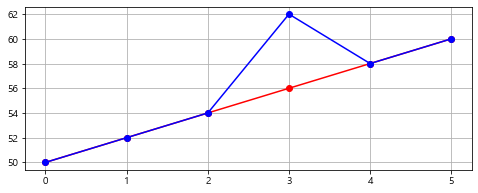

In [21]:
plt.figure(figsize=(8, 3)) # 단위: 인치
plt.plot(X, p, color='red', linestyle='solid', marker='o')  # 예측 성적
plt.plot(X, r, color='blue', linestyle='solid', marker='o') # 실제 성적
plt.grid(True)
plt.show()

### 오차가 0이라고 오판하는 경우
- 모든 데이터의 오차를 알고 싶기 때문에 총 오차를 파악할 필요가 있음

In [22]:
# y = ax + b, y = 2x + 50, 기울기 a와 y 절편 b가 결정된 경우
X = [i for i in range(6)]  # 0 ~ 5: 공부 시간
print('데이터:', X)
a = 2  # 기울기
b = 50 # y 절편, 편향
p = [(a * x) + b for x in X] # 공식에의한 값 예측, p: Predict
print('모델에 의한 예측:', p)
r = p.copy() 
r[3] = r[3] + 6      # 3시간 공부한경우의 학생은 6점이 더 향상됨. 
r[4] = r[4] - 6      # 4시간 공부한경우의 학생은 -6점이 발생함. 
print('실제 취득 성적:', r)

데이터: [0, 1, 2, 3, 4, 5]
모델에 의한 예측: [50, 52, 54, 56, 58, 60]
실제 취득 성적: [50, 52, 54, 62, 52, 60]


In [23]:
# 편차의 상쇄, 편차의 합은 0, 오차의 상쇄
err = 0
for i in range(6):
    fmt = '공부한 시간 {0}, 예측 성적 {1}, 실제 성적 {2}, 오차 {3}'
    print(fmt.format(X[i], p[i], r[i], r[i] - p[i]))
    err = err + (p[i] - r[i]) # 오차의 합 산출
print('오차:', err)

공부한 시간 0, 예측 성적 50, 실제 성적 50, 오차 0
공부한 시간 1, 예측 성적 52, 실제 성적 52, 오차 0
공부한 시간 2, 예측 성적 54, 실제 성적 54, 오차 0
공부한 시간 3, 예측 성적 56, 실제 성적 62, 오차 6
공부한 시간 4, 예측 성적 58, 실제 성적 52, 오차 -6
공부한 시간 5, 예측 성적 60, 실제 성적 60, 오차 0
오차: 0


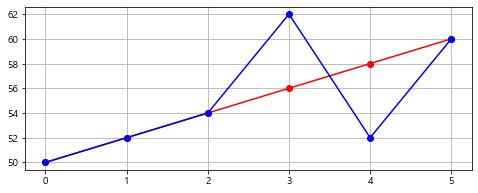

In [24]:
plt.figure(figsize=(8, 3)) # 단위: 인치
plt.plot(X, p, color='red', linestyle='solid', marker='o')  # 예측 성적
plt.plot(X, r, color='blue', linestyle='solid', marker='o') # 실제 성적
plt.grid(True)
plt.show()
# 오차가 존재하나 오차 6 + -6이되어 오차의 합이 0이 나오는 논리적 모순이 있음.
# 0임으로 오차는 없는 것인가? 수학적으로는 0임으로 오차는 없으나 모순임.
# 통계에서 편차의 합은 0

### 오차의 성질

In [24]:
data = [[0, 79], # [공부시간, 성적]
        [2, 81],
        [4, 93],
        [6, 91],
        [8, 97]] # list

for row in data:
    print(row)

[0, 79]
[2, 81]
[4, 93]
[6, 91]
[8, 97]


In [26]:
# X = data[:, 0] # X
# X = [row[0] for row in data] # O
X = np.array(data)[:,0]
print(X)
R = np.array(data)[:,1]
print(R)

[0 2 4 6 8]
[79 81 93 91 97]


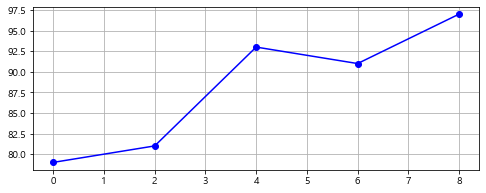

In [27]:
plt.figure(figsize=(8, 3)) # 단위: 인치
plt.plot(X, R, color='blue', linestyle='solid', marker='o')
plt.grid(True)
plt.show()

공부시간: 0, 예측: 80.000, 실제: 79, 오차: 1.000
공부시간: 2, 예측: 86.600, 실제: 81, 오차: 5.600
공부시간: 4, 예측: 93.200, 실제: 93, 오차: 0.200
공부시간: 6, 예측: 99.800, 실제: 91, 오차: 8.800
공부시간: 8, 예측: 106.400, 실제: 97, 오차: 9.400
제곱하지않은 순수 오차의 합: 25.0


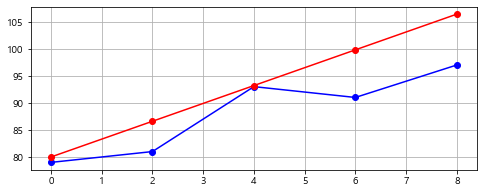

In [28]:
# y = ax + b, y = 3.3 * x + 80 모델 가정
a = 3.3 # 기울기 예측
b = 80  # y절편 예측
p_list = [] # 성적 예측 목록
err_tot = 0  # 오차 총합
for i in range(len(X)): # 0 ~ 4
    p = a * X[i] + b    # 모델 사용, X = [0, 2, 4, 6, 8]
    p_list.append(p)    # 예측 목록
    err = p - R[i]      # 제곱하지않은 순수 오차, 예측값 - 실제값
    err_tot = err_tot + err # 오차합
    fmt = '공부시간: {0}, 예측: {1:.3f}, 실제: {2}, 오차: {3:.3f}'
    print(fmt.format(X[i], p, R[i], err))
    
print('제곱하지않은 순수 오차의 합:', err_tot)    
# 실제 성적보다 예측 성적이 높음

# 실제 성적보다 추세선이 높게 그려짐.
plt.figure(figsize=(8, 3)) # 단위: 인치
plt.plot(X, R, color='blue', linestyle='solid', marker='o') # 실제
plt.plot(X, p_list, color='red', linestyle='solid', marker='o') # 예측
plt.grid(True)
plt.show()

공부시간: 0, 예측: 75.000, 실제: 79, 오차: -4.000
공부시간: 2, 예측: 77.600, 실제: 81, 오차: -3.400
공부시간: 4, 예측: 80.200, 실제: 93, 오차: -12.800
공부시간: 6, 예측: 82.800, 실제: 91, 오차: -8.200
공부시간: 8, 예측: 85.400, 실제: 97, 오차: -11.600
제곱하지않은 순수 오차의 합: -40.0


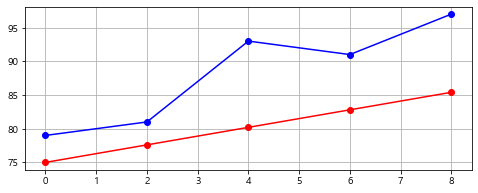

In [29]:
# y = ax + b, 모델: y = 1.3 * x + 75 모델 가정
a = 1.3
b = 75
p_list = [] # 성적 예측 목록
err_tot = 0  # 오차 총합
for i in range(len(X)):
    p = a * X[i] + b
    p_list.append(p) # 예측 목록
    err = p - R[i]    # 제곱하지않은 순수 오차, 예측값 - 실제값 
    err_tot = err_tot + err # 오차합
    fmt = '공부시간: {0}, 예측: {1:.3f}, 실제: {2}, 오차: {3:.3f}'
    print(fmt.format(X[i], p, R[i], err))
print('제곱하지않은 순수 오차의 합:', err_tot)    
# 실제 성적보다 예측 성적이 높음

# 실제 성적보다 추세선이 낮게 그려짐.
plt.figure(figsize=(8, 3)) # 단위: 인치
plt.plot(X, R, color='blue', linestyle='solid', marker='o') # 실제
plt.plot(X, p_list, color='red', linestyle='solid', marker='o') # 예측
plt.grid(True)
plt.show()

공부시간: 0, 예측: 79.000, 실제: 79, 오차: 0.000
공부시간: 2, 예측: 83.600, 실제: 81, 오차: 2.600
공부시간: 4, 예측: 88.200, 실제: 93, 오차: -4.800
공부시간: 6, 예측: 92.800, 실제: 91, 오차: 1.800
공부시간: 8, 예측: 97.400, 실제: 97, 오차: 0.400
제곱하지않은 순수 오차의 합:0.000


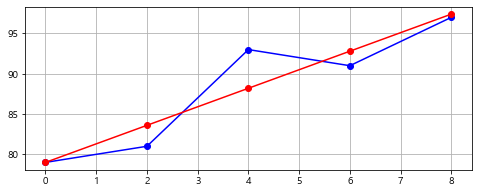

In [30]:
# 통계에 기반해서 또는 운이 좋아 기울기와 y 절편을 찾은 경우
# y = ax + b
a = 2.30001
b = 79
p_list = [] # 성적 예측 목록
err_tot = 0  # 오차 총합
for i in range(len(X)):
    p = a * X[i] + b
    p_list.append(p) # 예측 목록, 모델: y = 2.30001 * x + 79
    err = p - R[i]    # 제곱하지않은 순수 오차
    err_tot = err_tot + err # 오차합
    fmt = '공부시간: {0}, 예측: {1:.3f}, 실제: {2}, 오차: {3:.3f}'
    print(fmt.format(X[i], p, R[i], err))
print('제곱하지않은 순수 오차의 합:{0:.3f}'.format(err_tot))    
# 실제 성적보다 예측 성적이 높음, 최적의 추세선의 편차의 합은 0

# 추세선이 최적의 모양인 경우
plt.figure(figsize=(8, 3)) # 단위: 인치
plt.plot(X, R, color='blue', linestyle='solid', marker='o') # 실제
plt.plot(X, p_list, color='red', linestyle='solid', marker='o') # 예측
plt.grid(True)
plt.show()

In [32]:
# 오차가 존재하나 오차의 합이 0이 나옴
# 실제 데이터와 예측값의 오차가 없는것으로 판단하는 논리적 오류 발생
# MSE: 평균 제곱 오차 함수
def mse(p, r):  # p: 예측값, r: 실제값
    print('p.shape:', p.shape)   # (5,)
    print('r.shape:', r.shape)   # (5,)
    
    # 오차 제곱, 예측값(기대값)-실제값 = 평균(기대값)의 편차의 제곱
    se = (p - r) ** 2  
    print('se.shape:', se.shape) # (5,)
    mse = se.mean()    # 하나의 숫자(sclar), mean(): 평균 산출 = 분산
    print('mse.shape:', mse.shape)
    return mse

In [33]:
# list는 요소간의 vector 연산을 못함
# mse(p_list, R) # ERROR, unsupported operand type(s) for -: 'list' and 'list'
mse_val = mse(np.array(p_list), np.array(R))
print('MSE 오차: {0:.3f}'.format(mse_val))

p.shape: (5,)
r.shape: (5,)
se.shape: (5,)
mse.shape: ()
MSE 오차: 6.640


In [34]:
# 실제 오차, 표준 편차
print("mse: {0:.3f}, rmse: {1:.3f}".format(mse_val, np.sqrt(mse_val)))
# 실세계의 오차는 존재할 수 밖에 없음!!!

mse: 6.640, rmse: 2.577


In [ ]:
y = aX + b에서 데이터를 읽고 오차가 가장 작은 a, b를 찾는 과정을
머신러닝이라고함.
데이터의 규칙(패턴)을 발견하고 최적의 a, b를 찾게됨.
모델(a: 기울기, b: y 절편)이 발견되면 새로운 X를 대입하여 y를 예측 할 수 있음. 

- 하나의 변수에 대한 것은 y = a1X1 + b 로 예측 가능
- 2개이상의 변수 y = a1*X1 + a2*X2 + b 로 해결 가능
- 3개이상의 변수 y = a1*X1 + a2*X2 + a3*X3 + b 로 해결 가능
- 관계형 데이터베이스의 변수(컬럼)는 보통 10 ~ 20개 이상임으로 
- 개발자가 직접 선형회귀 구현 어려움

선형회귀를 이용한 도시형/귀촌/귀농에 성공한 사람들의 패턴을 파악하여 고객 진단
- 시골에 가족(친척)이 있는지 여부
- 시골에서 생활한 경험
- 자택 소유
- 토지
- 1년의 여행 횟수
- 음주 횟수
- 운전면허 소유 여부
- 차량 소유 여부
- 성격
- 판정(도시형/귀촌/귀농), class

머신러닝은 선형회귀/분류 알고리즘을 이용하여 도시형인지 시골형인지 진단
딥러닝 신경망(회귀)에 기반하여 도시형인지 시골형인지 진단